### Convolutional VAEs for MNIST handwritten-digits and fashion datset

#### Reference
Implemented based on the following references: <br>
    (1) https://www.tensorflow.org/tutorials/generative/cvae <br>
    (2) https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73 <br>
    (3) https://arxiv.org/pdf/1907.08956.pdf

#### Warnings
This Jupyter notebook is assumed to be executed on Google Colab.

#### GitHub repo clone/pull

In [ ]:
!git clone https://github.com/Daisuke0713/ANN-final.git
%cd ./ANN-final/VAEs

#### Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras, random, nn
from keras import Model, Input
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Layer

#### GPU/CPU settings

In [3]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
# set CPU the device for now
device = gpu_device

2023-04-19 22:20:29.352148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
if gpu_device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_device))

#### Congif Hyper-Parameters

In [4]:
epochs = 10
batch_size = 32
latent_dim = 100
learning_rate = 1e-4

#### Data Pre-processing

In [5]:
# get data
(x_train_digits, _), (x_test_digits, _) = keras.datasets.mnist.load_data()
(x_train_fashion, _), (x_test_fashion, _) = keras.datasets.fashion_mnist.load_data()

def preprocess_digits_image_data(data):
    # reshape, normalize, and binarize (gray) data
    image_data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 1)) / 255.
    return np.where(image_data < 0.5, 0.0, 1.0).astype('float32')

def preprocess_fashion_image_data(data):
    # reshape and normalize
    shape = data.shape
    image_data = data.reshape((shape[0], shape[1], shape[2], 1)) / 255.
    return image_data.astype('float32')

# preprocess data
x_train_digits = preprocess_digits_image_data(x_train_digits)
x_test_digits = preprocess_digits_image_data(x_test_digits)

x_train_fashion = preprocess_fashion_image_data(x_train_fashion)
x_test_fashion = preprocess_fashion_image_data(x_test_fashion)

#### Loss function

To construct our loss function, let us define a few variables as follows: 
1. $x$: input data, or evidence (in our case, images)
2. $z$: sampled latent representation from $p(z|x)$
3. $p(x)$: evidence distribution
4. $p(z)$: prior distribution
5. $p(z|x)$: posterior distribution, which defines the encoder of our VAE
6. $p(x|z)$: likelihood probability, which defines the decoder of our VAE

Following the reference, we have the loss function given by $$\text{loss} = C||x-\hat{x}||^2 + \text{KL}(N(\mu_{x}, \theta_{x}), N(0,1)),$$
where KL is the KL divergence of the two Gaussians and $C > 0$. We use $\hat{x}$ to denote the likelihhod pobability p(x|z), and assume that $p(z)$ follows the standard Gaussian and $p(z|x)$ follows a Gauussian characterized by the two output of the encoder network (the mean and log variance). Because $p(z|x)$ is intractable, we use $q(z|x) to denote the approximation of $p(z|x)$. Overall, this loss in very interpretable, as the first likelihood term characterizes the construction error (it does not need to be MSE, and we use cross entropy in our code) and the second KL term is for the regularization of the network (so that our latent space becomes more continuous and complete, which enables the generative proceedur).

Now, rather than implementating this loss function, we will construct another loss function that is more easily implementable. Our objective function is (not the loss)
$$\text{argmin}\left[C||x-\hat{x}||^2 + KL\left(q(z|x), p(z)\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] - KL\left(q(z|x), p(z)\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] + \int q(z|x)\text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] + \mathbb{E}_{z \sim q(z|x)}\text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z) + \text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}\left(\frac{p(x|z)p(z)}{q(z|x)}\right)\right]\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z) + \text{log}p(z) - \text{log}q(z|x)\right]\right].$$

This objective function gives a new loss
$$\text{loss} = \text{log}p(x|z) + \text{log}p(z) - \text{log}q(z|x).$$

In [14]:
def log_normal(sample, mean, logvar):
    with tf.device(device):
        prob = -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + tf.math.log(2.0 * np.pi))
        return tf.reduce_sum(prob, axis=1)

def get_loss(model, x):
    with tf.device(device):
        mean, logvar, z = model.encoder(x) # z sampled from q(z|x)
        xhat = model.decoder(z) # generated by obtaining p(x|z)
        prob = nn.sigmoid_cross_entropy_with_logits(labels=x, logits=xhat)

        logpxz = -tf.reduce_sum(prob, axis=[1,2,3]) # just reconstruction error
        logpz = log_normal(z, mean, logvar) # standard Gaussian (assumed)
        logqzx = log_normal(z, mean, logvar) # Gaussian obtained through encoder

        # return the average value for each sample within this batch
        return -tf.reduce_mean(logpxz + logpz - logqzx)

def get_default_loss(model, x):
    with tf.device(device):
        mean, logvar, z = model.encoder(x)
        xhat = model.decoder(z)
        rl = tf.reduce_mean(keras.losses.binary_crossentropy(x, xhat))*28*28
        kl = tf.reduce_mean(1+logvar-tf.square(mean)-tf.exp(logvar)) * -0.5
        return rl + kl

#### Define VAEs

In [15]:
'''Sampling layer'''
class Sampling(Layer):

    def call(self, prob):
        mean, logvar = tf.split(prob, num_or_size_splits=2, axis=1)
        e = random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))
        z = mean + e * tf.exp(logvar * 0.5)
        return mean, logvar, z

'''Basic Convolutional VAE'''
class VAE(Model):

    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()

    '''encoder + reparametrization (i.e., sampling) layer'''
    def get_encoder(self):
        input_x = Input(shape=(28,28,1))
        x = Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(input_x)
        x = Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
        x = Flatten()(x)
        x = Dense(self.latent_dim * 2)(x)
        (mean, logvar, z) = Sampling()(x)
        return Model(input_x, [mean, logvar, z], name="encoder")

    '''decoder'''
    def get_decoder(self):
        input_z = Input(shape=(self.latent_dim,))
        z = Dense(7*7*64, activation="relu")(input_z)
        z = Reshape((7, 7, 64))(z)
        z = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(z)
        z = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(z)
        xhat = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(z)
        return  Model(input_z, xhat, name="decoder")

    '''train'''
    def train_step(self, x):
        with tf.device(device):
            x = x[0] if isinstance(x, tuple) else x
            with tf.GradientTape() as tape:
                loss = get_default_loss(self, x)
            gradient = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.trainable_weights))
            return {"loss": loss}

    def call(self, inputs):
       pass

# instansiate model
vae = VAE(latent_dim=latent_dim)
vae.compile(optimizer=Adam(learning_rate=learning_rate))
vae.build(input_shape=(28,28,1))
vae.summary()

Model: "vae_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               46788     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         83841     
                                                                 
Total params: 130,629
Trainable params: 130,629
Non-trainable params: 0
_________________________________________________________________


In [16]:
'''define call backs'''
def generate():
    ramdom_vector_z = np.random.normal(loc=0, scale=1, size=(16, latent_dim))
    generated = vae.decoder(ramdom_vector_z)
    return generated

def save_img(imgs, filename=None):
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'./images/{filename}.png')

def call_back(epoch, _):
    if epoch % 10 == 0:
        random_vector_z = tf.random.normal(shape=(16, latent_dim))
        generated = vae.decoder(random_vector_z)
        save_img(generated, f'epoch{epoch}_batch{batch_size}_latent{latent_dim}')

callbacks = LambdaCallback(on_epoch_end=call_back)

#### Training and generating

In [ ]:
vae.fit(x=x_train_digits, epochs=epochs, batch_size=batch_size, callbacks=[callbacks])
# vae.save_weights('base')
#  Note: 15sec per epoch

In [ ]:
!zip -r ./images.zip images

#### Latent Space Visualization (for 2 dimensions)

In [13]:
# switch latent dimension to 2 (for the sake of visualization)
latent_dim = 2
epochs = 100

In [17]:
# fit the model
vae = VAE(latent_dim=latent_dim)
vae.compile(optimizer=Adam(learning_rate=learning_rate))
vae.build(input_shape=(28,28,1))

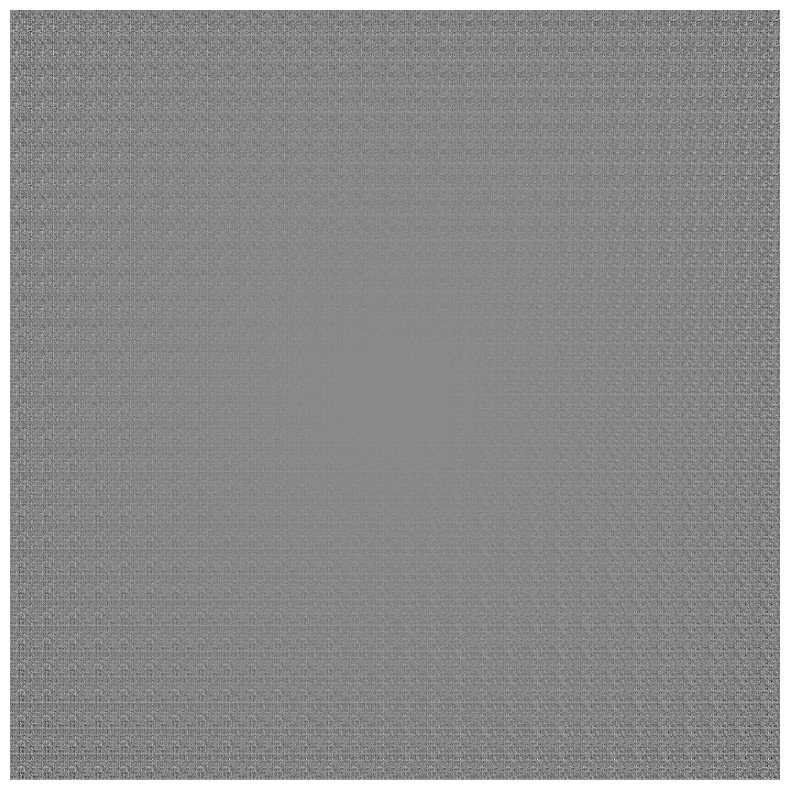

In [22]:
import tensorflow_probability as tfp

# visualize latent dim
def show_latent_image(n, epoch):
    std_normal = tfp.distributions.Normal(0,1)
    x = std_normal.quantile(np.linspace(0.05, 0.95, n))
    y = std_normal.quantile(np.linspace(0.05, 0.95, n))
    size = 28 * n
    latent_image = np.zeros(shape=(size, size))

    for i, y_i in enumerate(x):
        for j, x_i in enumerate(y):
            latent_z = np.array([[x_i, y_i]])
            generated_x = tf.reshape(vae.decoder(latent_z)[0], (28,28)).numpy()
            latent_image[i*28:(i+1)*28, j*28:(j+1)*28] = generated_x

    plt.figure(figsize=(10,10))
    plt.imshow(latent_image, cmap='gray')
    plt.axis('Off')
    plt.savefig(f'./latent{epoch}.png')
    plt.show()

# show tye intial latent space
show_latent_image(n=30, epoch=0)      

In [ ]:
# show the learned latent space
vae.fit(x=x_train_digits, epochs=epochs, batch_size=batch_size)
show_latent_image(n=30, epoch=100)